In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import datetime
import math
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

2024-10-16 00:39:40.443182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 00:39:40.506642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 00:39:40.510450: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 00:39:40.575739: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 00:39:41.518855: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras import mixed_precision

# # Set the global policy to mixed precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

I0000 00:00:1728999582.916197    5327 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728999583.823381    5327 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728999583.825539    5327 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# import os

# # Set the environment variable
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


I0000 00:00:1728999583.854950    5327 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728999583.857548    5327 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728999583.859722    5327 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728999583.963197    5327 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [6]:
# data = pd.read_csv("C:\Users\alanx\OneDrive - The University of Sydney (Students)\Thesis\Deep Learning\wifi_localization\data\csv\ultimate_combined.csv")
# data = pd.read_csv("data/csv/ultimate_combined.csv")
data = pd.read_csv("data/csv/still/still.csv")
# data = pd.read_csv("data/csv/still_with_receiver/still_with_receiver.csv")

data.head()

,nc,rssi,rssi1,rssi2,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,with_receiver,coord1,coord2,ant1_amplitude_cluster,ant2_amplitude_cluster
0,1,-0.910605,-0.551767,-0.947813,1,0.080161,0.716936,1.632341,0.081637,0,6,2,0.0,1.0
1,1,-0.910605,-0.551767,-0.947813,2,0.050665,0.765282,1.613039,0.069161,0,6,2,0.0,1.0
2,1,-0.910605,-0.551767,-0.947813,3,0.034689,0.716998,1.575497,0.066240,0,6,2,0.0,1.0
3,1,-0.910605,-0.551767,-0.947813,4,-0.014982,0.698775,1.568640,0.054993,0,6,2,0.0,1.0
4,1,-0.910605,-0.551767,-0.947813,5,-0.038545,0.842687,1.580335,0.041922,0,6,2,0.0,1.0


In [7]:
data.drop('with_receiver', axis=1, inplace=True)
# data.drop('nc', axis=1, inplace=True)
# data.drop('ant1_phase', axis=1, inplace=True)
# data.drop('ant2_phase', axis=1, inplace=True)

In [8]:
data = pd.concat([data, pd.get_dummies(data['subcarriers'], prefix='subcarrier')], axis=1)
data.drop('subcarriers', axis=1, inplace=True)
data.head()

,nc,rssi,rssi1,rssi2,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,coord1,coord2,...,subcarrier_47,subcarrier_48,subcarrier_49,subcarrier_50,subcarrier_51,subcarrier_52,subcarrier_53,subcarrier_54,subcarrier_55,subcarrier_56
0,1,-0.910605,-0.551767,-0.947813,0.080161,0.716936,1.632341,0.081637,6,2,...,False,False,False,False,False,False,False,False,False,False
1,1,-0.910605,-0.551767,-0.947813,0.050665,0.765282,1.613039,0.069161,6,2,...,False,False,False,False,False,False,False,False,False,False
2,1,-0.910605,-0.551767,-0.947813,0.034689,0.716998,1.575497,0.066240,6,2,...,False,False,False,False,False,False,False,False,False,False
3,1,-0.910605,-0.551767,-0.947813,-0.014982,0.698775,1.568640,0.054993,6,2,...,False,False,False,False,False,False,False,False,False,False
4,1,-0.910605,-0.551767,-0.947813,-0.038545,0.842687,1.580335,0.041922,6,2,...,False,False,False,False,False,False,False,False,False,False


# Model

In [9]:
model_type = "dnn"

In [10]:
X = data.drop(columns=['coord1', 'coord2']) 
y = data[['coord1', 'coord2']]

# X = X.values.astype(np.float32)
# y = y.values.astype(np.float32)

In [11]:
# np.save('preprocessed_X.npy', X)
# np.save('preprocessed_y.npy', y)

In [12]:
# X = np.load('preprocessed_X.npy')
# y = np.load('preprocessed_y.npy')

In [13]:
# dataset = tf.data.Dataset.from_tensor_slices((X, y))

# batch_size = 128  # Adjust based on your GPU memory

# dataset = dataset.shuffle(buffer_size=10000)
# dataset = dataset.batch(batch_size)
# dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [14]:
# First, split the data into training and a temporary set (which will later be split into validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train, 40% temp

# Now, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% val, 20% test

# Check the shapes of your splits
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (4146846, 66)
Validation set shape: (1382282, 66)
Test set shape: (1382283, 66)


In [15]:
def create_dnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))

    # Hidden layers
    # model.add(layers.Dense(8192, activation='relu'))
    # model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    # model.add(layers.Dense(256, activation='relu'))
    # model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dense(16, activation='relu'))

    # Output layer
    model.add(layers.Dense(2))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Example of creating the model, input_shape should be (number of features,)
input_shape = (X_train.shape[1],)  # Adjust based on your number of features
model = create_dnn_model(input_shape)

# Print the model summary
model.summary()

/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1728999595.489723    5327 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728999595.490984    5327 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728999595.491972    5327 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA no

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,153,922 (42.55 MB)

 Trainable params: 11,153,922 (42.55 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='./models/checkpoint/model_checkpoint_{epoch:02d}_{val_loss:.2f}.keras',     # Path where the model will be saved
    monitor='val_loss',                 # Monitor the validation loss for improvements
    save_best_only=True,                # Only save the model if it's the best one seen so far
    save_weights_only=False,            # Save the entire model (set to True to save only weights)
    mode='min',                         # In case of loss, use 'min' (use 'max' for accuracy)
    verbose=1                           # Print a message when saving the model
)

# model = load_model('./models/checkpoint/model_checkpoint_42_0.59.keras')

# Train the model
with tf.device('/GPU:0'):
    history = model.fit(
                        # dataset,
                        X_train, y_train, 
                        epochs=50, 
                        batch_size=128, 
                        validation_data=(X_val, y_val),
                        callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), checkpoint])

    # Evaluate the model on test data
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


Epoch 1/50


I0000 00:00:1728999598.830690    7119 service.cc:146] XLA service 0x7dc86000c7c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728999598.830704    7119 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-10-16 00:39:58.854832: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-16 00:39:59.146659: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-16 00:39:59.958264: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_235', 132 bytes spill stores, 132 bytes spill loads

2024-10-16 00:40:00.244940: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in fu

   36/32398 ━━━━━━━━━━━━━━━━━━━━ 1:35 3ms/step - loss: 484.0512 - mae: 7.5418 

I0000 00:00:1728999605.279038    7119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32382/32398 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4473 - mae: 1.3677

2024-10-16 00:41:31.578317: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_235', 204 bytes spill stores, 204 bytes spill loads

2024-10-16 00:41:32.002275: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_277', 44 bytes spill stores, 44 bytes spill loads

2024-10-16 00:41:32.193660: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_235', 80 bytes spill stores, 80 bytes spill loads

2024-10-16 00:41:32.280837: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_277', 200 bytes spill stores, 200 bytes spill loads

2024-10-16 00:41:33.006105: I external/local_xla/xla/stream_

32398/32398 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4463 - mae: 1.3676

2024-10-16 00:41:45.302017: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_loss improved from inf to 1.86812, saving model to ./models/checkpoint/model_checkpoint_01_1.87.keras
32398/32398 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - loss: 4.4463 - mae: 1.3676 - val_loss: 1.8681 - val_mae: 1.0231
Epoch 2/50
32381/32398 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8020 - mae: 0.9951
Epoch 2: val_loss improved from 1.86812 to 1.57805, saving model to ./models/checkpoint/model_checkpoint_02_1.58.keras
32398/32398 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 1.8020 - mae: 0.9951 - val_loss: 1.5780 - val_mae: 0.9087
Epoch 3/50
32382/32398 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5431 - mae: 0.8908
Epoch 3: val_loss improved from 1.57805 to 1.40999, saving model to ./models/checkpoint/model_checkpoint_03_1.41.keras
32398/32398 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - loss: 1.5431 - mae: 0.8908 - val_loss: 1.4100 - val_mae: 0.8373
Epoch 4/50
32385/32398 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3834 - mae: 0.8257
Epoch 4: val_loss improved from 1.40999 to 1.28402, sa

2024-10-16 01:54:15.938717: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 132 bytes spill stores, 132 bytes spill loads

2024-10-16 01:54:16.357710: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 132 bytes spill stores, 132 bytes spill loads

2024-10-16 01:54:16.443880: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 4 bytes spill stores, 4 bytes spill loads

2024-10-16 01:54:16.603755: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_46', 132 bytes spill stores, 132 bytes spill loads

2024-10-16 01:54:17.140354: I external/local_xla/xla/stream_exec

43161/43197 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5090 - mae: 0.4291

2024-10-16 01:54:47.865222: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 4 bytes spill stores, 4 bytes spill loads



43197/43197 ━━━━━━━━━━━━━━━━━━━━ 33s 707us/step - loss: 0.5090 - mae: 0.4291
Test Loss: 0.5080314874649048, Test MAE: 0.4286692142486572


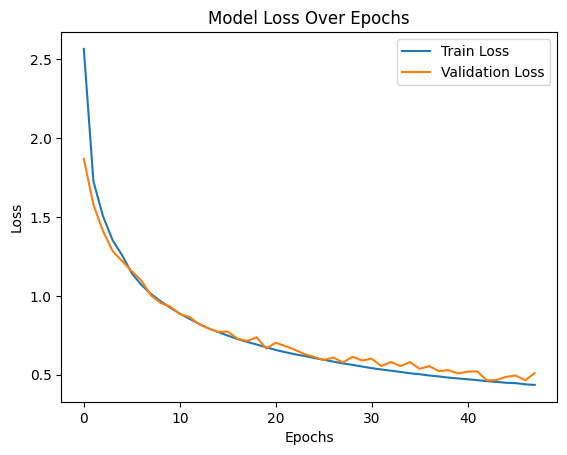

In [17]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
# After training your model
y_pred = model.predict(X_test)

43197/43197 ━━━━━━━━━━━━━━━━━━━━ 26s 591us/step


In [19]:
# Convert y_test to NumPy array with float64 data type
y_test_np = y_test.to_numpy(dtype=np.float64)

# Ensure y_pred is a NumPy array with float64 data type
y_pred_np = np.array(y_pred, dtype=np.float64)

In [20]:
# Assuming y_test and y_pred are NumPy arrays
absolute_errors = np.abs(y_test_np - y_pred_np)
coordinate_ranges = np.ptp(y_test_np, axis=0)  # Peak to peak (max - min) along each coordinate

# Avoid division by zero
coordinate_ranges[coordinate_ranges == 0] = 1

relative_errors = absolute_errors / coordinate_ranges
mean_relative_error = np.mean(relative_errors, axis=0)

print(f"Mean Relative Error for coord1: {mean_relative_error[0]:.4f}")
print(f"Mean Relative Error for coord2: {mean_relative_error[1]:.4f}")


Mean Relative Error for coord1: 0.0783
Mean Relative Error for coord2: 0.0775


In [21]:
from scipy.stats import spearmanr

rho_coord1, _ = spearmanr(y_test_np[:, 0], y_pred_np[:, 0])
rho_coord2, _ = spearmanr(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Spearman's Rank Correlation for coord1: {rho_coord1:.4f}")
print(f"Spearman's Rank Correlation for coord2: {rho_coord2:.4f}")


Spearman's Rank Correlation for coord1: 0.9221
Spearman's Rank Correlation for coord2: 0.8963


In [22]:
# Create a mapping from coordinate pairs to class labels
unique_coords = np.unique(y_test_np, axis=0)
coord_to_label = {tuple(coord): idx for idx, coord in enumerate(unique_coords)}

# Convert coordinates to labels
y_test_labels = np.array([coord_to_label[tuple(coord)] for coord in y_test_np])
y_pred_labels = np.array([coord_to_label.get(tuple(coord), -1) for coord in y_pred_np])  # Use -1 for unknowns


In [23]:
# from sklearn.metrics import accuracy_score, confusion_matrix

# # Filter out predictions that don't map to a valid label
# valid_indices = y_pred_labels != -1
# accuracy = accuracy_score(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# print(f"Classification Accuracy: {accuracy:.4f}")


In [24]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay

# cm = confusion_matrix(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix of Predicted vs Actual Classes')
# plt.show()

In [25]:
scaler = StandardScaler()
y_test_scaled = scaler.fit_transform(y_test_np)
y_pred_scaled = scaler.transform(y_pred_np)

# Compute Mean Squared Error on standardized data
from sklearn.metrics import mean_squared_error

mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"MSE on Standardized Coordinates: {mse_scaled:.4f}")


MSE on Standardized Coordinates: 0.1652


In [26]:
def custom_accuracy(y_true, y_pred, tolerance):
    # Count predictions within a certain tolerance
    correct_predictions = np.all(np.abs(y_true - y_pred) <= tolerance, axis=1)
    accuracy = np.mean(correct_predictions)
    return accuracy

tolerances = [1, 0.5, 0.1]  # Adjust based on your coordinate system

for tolerance in tolerances:
    accuracy = custom_accuracy(y_test_np, y_pred_np, tolerance)
    print(f"Accuracy within tolerance {tolerance}: {accuracy:.4f}")

accuracy = custom_accuracy(y_test_np, y_pred_np, 1)

Accuracy within tolerance 1: 0.8221
Accuracy within tolerance 0.5: 0.6230
Accuracy within tolerance 0.1: 0.1018


In [27]:
tolerances = [1, 0.5, 0.1]  # Adjust based on your coordinate system

y_pred_np_rounded = np.round(y_pred_np)

for tolerance in tolerances:
    accuracy = custom_accuracy(y_test_np, y_pred_np_rounded, tolerance)
    print(f"Accuracy within tolerance {tolerance}: {accuracy:.4f}")

accuracy = custom_accuracy(y_test_np, y_pred_np, 1)

Accuracy within tolerance 1: 0.9036
Accuracy within tolerance 0.5: 0.6230
Accuracy within tolerance 0.1: 0.6230


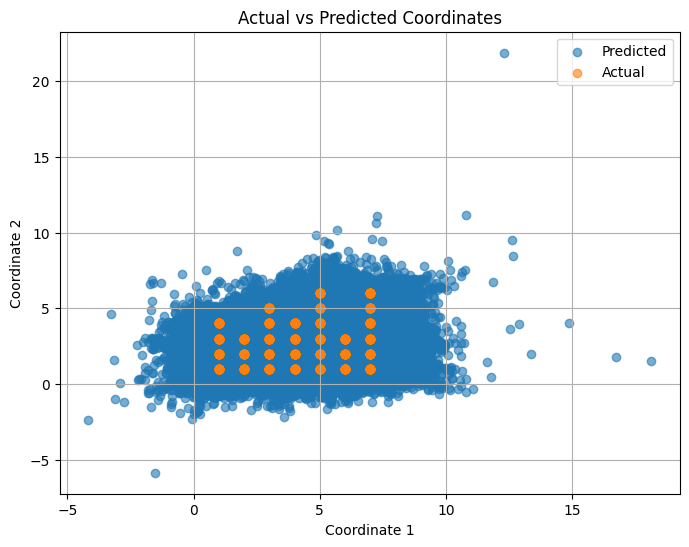

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_np[:, 0], y_pred_np[:, 1], label='Predicted', alpha=0.6)
plt.scatter(y_test_np[:, 0], y_test_np[:, 1], label='Actual', alpha=0.6)
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.title('Actual vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# MAE for each coordinate
mae_coord1 = mean_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
mae_coord2 = mean_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

# Overall MAE
mae_overall = np.mean([mae_coord1, mae_coord2])

print(f"MAE for coord1: {mae_coord1:.4f}")
print(f"MAE for coord2: {mae_coord2:.4f}")
print(f"Overall MAE: {mae_overall:.4f}")

# RMSE for each coordinate
rmse_coord1 = np.sqrt(mean_squared_error(y_test_np[:, 0], y_pred_np[:, 0]))
rmse_coord2 = np.sqrt(mean_squared_error(y_test_np[:, 1], y_pred_np[:, 1]))

# Overall RMSE
rmse_overall = np.mean([rmse_coord1, rmse_coord2])

print(f"RMSE for coord1: {rmse_coord1:.4f}")
print(f"RMSE for coord2: {rmse_coord2:.4f}")
print(f"Overall RMSE: {rmse_overall:.4f}")

# Calculate Euclidean distances
distance_errors = np.linalg.norm(y_test_np - y_pred_np, axis=1)
mean_distance_error = np.mean(distance_errors)

print(f"Mean Euclidean Distance Error: {mean_distance_error:.4f} units")

# R-squared for each coordinate
r2_coord1 = r2_score(y_test_np[:, 0], y_pred_np[:, 0])
r2_coord2 = r2_score(y_test_np[:, 1], y_pred_np[:, 1])

print(f"R-squared for coord1: {r2_coord1:.4f}")
print(f"R-squared for coord2: {r2_coord2:.4f}")

# Median Absolute Error for each coordinate
medae_coord1 = median_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
medae_coord2 = median_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Median Absolute Error for coord1: {medae_coord1:.4f}")
print(f"Median Absolute Error for coord2: {medae_coord2:.4f}")

MAE for coord1: 0.4700
MAE for coord2: 0.3873
Overall MAE: 0.4287
RMSE for coord1: 0.7818
RMSE for coord2: 0.6363
Overall RMSE: 0.7090
Mean Euclidean Distance Error: 0.6748 units
R-squared for coord1: 0.8473
R-squared for coord2: 0.8223
Median Absolute Error for coord1: 0.2547
Median Absolute Error for coord2: 0.2005


In [30]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer

# def mean_euclidean_error(y_true, y_pred):
#     return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

# # Create a scorer based on your custom metric
# scorer = make_scorer(mean_euclidean_error, greater_is_better=False)

# # Assuming you have a model compatible with scikit-learn's API
# scores = cross_val_score(model, X, y, cv=5, scoring=scorer)
# print(f"Cross-validated Mean Euclidean Distance Error: {-np.mean(scores):.4f}")


TypeError: Cannot clone object '<Sequential name=sequential, built=True>' (type <class 'keras.src.models.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [31]:
now = datetime.datetime.now()
date_time = now.strftime("%m-%d-%H-%M")

model.save(f"./models/{date_time}-{model_type}-{accuracy:.2f}.keras")